In [1]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt

In [2]:
# Inputs
filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\lora.sig"
f_sample = 150000           # Sample Rate
sf = 7                      # Spreading Factor
n = 2^(sf)                  # bits pro Symbol
bw = 125e3                  # Bandbreite der Übertragung

In [3]:
# read in I/Q samples from binary file
n_float32 = int(stat(filename).st_size/4)
with open(filename,"rb") as binary_file:
    arr = array('f')
    arr.fromfile(binary_file,n_float32)
rx = np.array(arr.tolist()[::2])+1j*np.array(arr.tolist()[1::2])
rx /= np.amax(np.abs(rx))
rx -= np.mean(rx)    # remove DC
print("signal size:",rx.shape[0])

signal size: 99942400


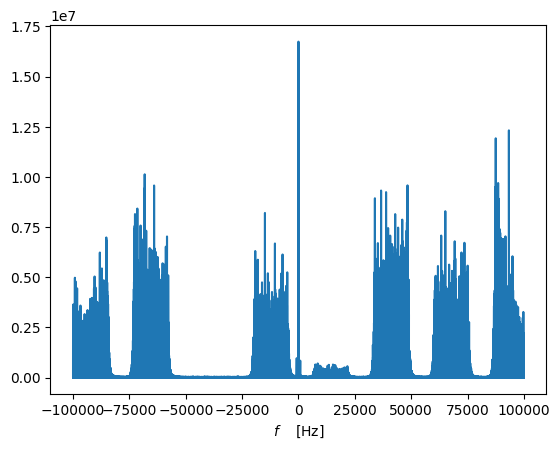

C:\Users\yanni\AppData\Local\Temp\ipykernel_14560\483970970.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(f_Hz,(np.sin(np.pi*f_Hz*t_symb)/(np.pi*f_Hz*t_symb))**2)


In [4]:
# Magnitudenspektrum (absolut)

f = np.abs(np.fft.fftshift(np.fft.fft(rx)))**2
f_Hz = f_sample*(np.arange(rx.shape[0])/rx.shape[0]-0.5)
plt.plot(f_Hz,f)
plt.xlabel('$f$    [Hz]')
plt.show()

t_symb = n/f_sample    # symbol duration T
plt.plot(f_Hz,(np.sin(np.pi*f_Hz*t_symb)/(np.pi*f_Hz*t_symb))**2)
plt.xlabel('$f$    [Hz]')
plt.show()

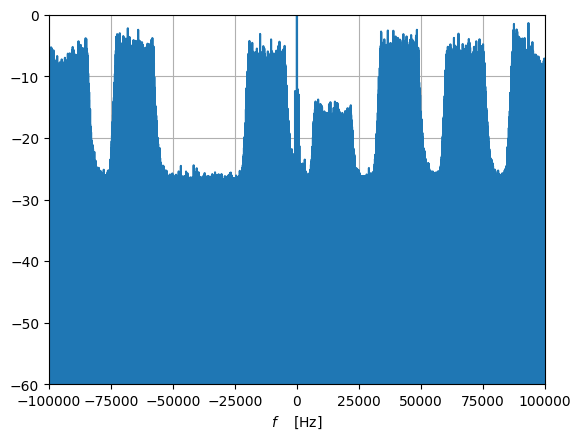

In [ ]:
# Magnitudenspektrum (dB)

f_dB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rx))))
f_dB -= np.amax(f_dB)
f_Hz = f_sample*(np.arange(rx.shape[0])/rx.shape[0]-0.5)
plt.plot(f_Hz,f_dB)
plt.xlabel('$f$    [Hz]')
plt.axis([-f_sample/2,f_sample/2,-60,0])
plt.grid()
plt.show()

In [3]:
# Spectrogram
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 64
    ts = 64
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()
    


In [ ]:
# Import
import scipy.signal as signal

rxd = signal.decimate(rx,8)
